* There is inherent(= inbuilt) time dependence in the input data of mechanical bearing for RUL prediction. 
* Using an LSTM network is an appropriate technique to learn pattern in a time series data

* Input data of the 6 bearing datasets are 1D data (1D vibration signals (both horizontal acceleration & vertical acceleration) & this 1D data contains only time domain information) 

* Directly analyzing 1D data(time domain is complicated as we cannot get more insights about the data & we cannot extract the necessary features properly from 1D data)

* Hence, we converted 1D data into 2D CWT feature image data 
(the obtained 2D data contains both time domain & frequency domain information)

* With time-frequency domain information, we can understand the data well & can extract impotant necessary features accurately from the data which helps to train the model ideally.

* Time-Frequency domain features clearly visualize the degradation (=damage) process of the bearings compared to time domain features

* Now, our input data is a 2D CWT image and also time dependent.

* Therefore using CNN + LSTM, because CNN works well for image like data, CNN analyzes the image inputs perfectly whereas LSTM perfomrs well for time-series data

* Time-series data = time-series data is a set of observations(data) usually collected at discrete & equally spaced time intervals

* Here, in our collected dataset, vibration signals are collected at every 10 seconds (different tiem & equal time intervals). Hence our data is time-series data

* And also LSTM is a good sequence model which perfomrs sequence modeling

* Our collected input data is represented as 2d CWT images, but a window of pre-defiend frames (Say 5) is used as a sequence.

* First passed through a CNN architecture for encoding and then encoded feature vector sequence is passes through LSTM architecture, hence CNN+LSTM  architecture

* In CNN+LSTM model, 

    1. 1st we inputted 2D CWT image to the CNN foe encoding 
(encoding is the process of converting the data from one form to another form)

    2. Then CNN is capable of analyzing images properly which helps in extracting better featres from the input image.

    3. After inptting 2D CWT images to the CNN Encoder, the CNN Encoder applies convolution, Batch Normalization, ReLU Activation to the inputted image 

    4. And CNN Encoder converts the 2D image input data into 1D linear continuous vector by flattening.

    5. This flattened vector sequence or encoded feature vector is then inputted to LSTM units or LSTM cells.

    6.  LSTM units or LSTM cells analyze the inputted vector sequences at different steps (t, t+1, t+2, t+3, t+4) & output the final time step(t+4) LSTM unit vector sequence, from which we calculate the HI (Health Indicator)


* LSTM cell or LSTM unit at time step t+1 takes output of LSTM cell at t time step and current encoded vector sequence(i.e. encoded vector sequence of CNN Encoder of t+1 time step image) as input

* LSTM cell or LSTM unit at time step t+2 takes output of LSTM cell at t+1 time step and current encoded vector sequence(i.e. encoded vector sequence of CNN Encoder of t+2 time step image) as input

* LSTM cell or LSTM unit at time step t+3 takes output of LSTM cell at t+2 time step and current encoded vector sequence(i.e. encoded vector sequence of CNN Encoder of t+3 time step image) as input

* LSTM cell or LSTM unit at time step t+4 takes output of LSTM cell at t+3 time step and current encoded vector sequence(i.e. encoded vector sequence of CNN Encoder of t+4 time step image) as input

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import numpy as np
import pickle as pkl
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from matplotlib import pyplot as plt

In [3]:
np.random.seed(1234) #initialize andom seed to generate same random values every time

In [4]:
dir = "/content/drive/MyDrive/FEMO2012 CHALLENGE /Dataset/1d_2d_merged_data"
bearing = ['Bearing1_1','Bearing1_2','Bearing2_1','Bearing2_2','Bearing3_1','Bearing3_2']

* Created PHMDataset_Sequential class using class keyword.
* we send Dataset as the parameter inside the class

* dataset_id = index of dataset to read from
* indices = indices from the dataset that needs to be included in the output sequence
* seq_len = length of the output seuence i.e., return a sequence of length 'seq_len' from the dataset as 'x' & fault probability of the last frame as 'y'


In [5]:
def load_file(path):
  with open(path, 'rb') as f:
    return(pkl.load(f))

class PHMDataset_Sequential(Dataset):

    def __init__(self, dataset_id=0, indices=[], seq_len=5):
        '''
        dataset_id = index(= position) of dataset to read from  (index = An index is a numerical representation of an item's(a data) position in a sequence)
        indices = indices from the dataset that needs to be included in the output sequence 
        seq_len = length of the output sequence (sequence output sample) i.e., return a sequence of length `seq_len` from the dataset as `x` and fault 
        probability of the last frame (last frame means last time output sequence, since it is a time series data) as `y` 
        '''
        self.dataset_id = dataset_id
        self.indices = indices 
        self.seq_len = seq_len 
    
    def __len__(self):
        return len(self.indices)
    
    def __getitem__(self, i):
        sample_id = self.indices[i] 
        sample = {'x': torch.from_numpy(DATA[self.dataset_id]['x'][sample_id:sample_id+self.seq_len]), 
                  'y': torch.from_numpy(DATA[self.dataset_id]['y'][sample_id+self.seq_len-1])}
        return sample

In [6]:
files = []
for b in bearing:
  path = os.path.join(dir, b + ".pkz")
  files.append(path)

DATA = []
for path in files:
  data = load_file(path)
  data['y'] = data['y'][:,np.newaxis]
  DATA.append(data)

Splitting into train data sequences & val data sequences & printing the no. of train data sequences & printing the no. of val data sequences of all 6 bearing pickle files

In [7]:
# DATA : DATA is a global list that contains the data of every pfile in pfiles (pfile represents pickle file)
# permutation - randomly changing the arrangement of data. (each of several possible ways in which a set of data or number of values can be ordered or arranged)
# perm = np.random.permutation(no_of_seqs) - Created perm variable and stored the sequences by applying permutation.
# (that means after every iteration a sequence with random order will be generated and stored in perm variable)

SEQ_LEN = 5 # sequence length
VAL_SPLIT = 0.1

train_datasets, val_datasets = [], []
for dataset_id in range(len(DATA)):
    no_of_files = DATA[dataset_id]['x'].shape[0]
    no_of_seqs = no_of_files-SEQ_LEN+1
    no_of_val = int(VAL_SPLIT*no_of_seqs)
    perm = np.random.permutation(no_of_seqs)
    val_indices = perm[0:no_of_val]
    train_indices = perm[no_of_val:]

    train_dataset = PHMDataset_Sequential(dataset_id=dataset_id, indices=train_indices, seq_len=SEQ_LEN) 
    val_dataset = PHMDataset_Sequential(dataset_id=dataset_id, indices=val_indices, seq_len=SEQ_LEN) 
    print(len(train_dataset), len(val_dataset)) 

    train_datasets.append(train_dataset) 
    val_datasets.append(val_dataset) 

2520 279
781 86
817 90
714 79
460 51
1470 163


In [8]:
#batch_size => no. of samples in each batch

train_batch_size = 16 #that means train dataset sequences divided into batches of data and each batch sequence contains 16 samples
val_batch_size = 16   #that means validation dataset sequences divided into batches of data and each batch sequence contains 16 samples

**torch DataLoader**

https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

* Batching data => splitting the dataset into a collection of smaller data chunks that are send into the model one at a time.


* Shuffling data => rearranging data or reorganizing data.

Data Shuffling is important because by shuffling the data, one can make sure that each data point creates a searate change on the model, without being affected by the same data points before them

* (optionally) load the data in parallel using multiprocessing workers

* torch.utils.data.DataLoader : it is an iterator that provides all the above mentioned features

* iterator in python is an object that is used to iterate over iterable objects like lists, tuples, dictionary & sets.

The iterator object is initialized using the iter() method

iterator uses the next() method for iteration

* iterable is an object, which one can iterate over. eg. tupes, list, dictionaries, sets.

  Iterable generates an iterator when passed to iter() method.

  iterator is an object, which is used to iterate over an object using next() method

* every iterator is also an iterable, but not every iterable is an iterator

NOTE:  if for loop is used to iterate over the data, then these features (Batching data, shuffling data) are not included which makes data loading somewhat difficult & requires more processing time

In [9]:
# here dataloader() that loads batch of 16 samples(train/val data sequences) at a time
train_dataloaders = []
for train_dataset in train_datasets:  
    train_dataloaders.append( DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True, num_workers=1) ) 

val_dataloaders = []
for val_dataset in val_datasets:  
    val_dataloaders.append( DataLoader(val_dataset, batch_size=val_batch_size, shuffle=False, num_workers=1) ) 

#MODEL ARCHITERCTURE (CNN + LSTM)

**CNN Model Architecture **

In [10]:
def conv_bn_relu(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros', batch_norm=True):
    conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=padding, dilation=dilation, groups=groups, bias=bias, padding_mode=padding_mode)
    nn.init.xavier_uniform_(conv.weight)
    relu = nn.ReLU()
    if batch_norm:
        return nn.Sequential(
            conv,
            nn.BatchNorm2d(out_channels),
            relu
        )
    else:
        return nn.Sequential(
            conv,
            relu
        )

**CNN for Encoding**
* Encoding - Encoding is the process of converting data from one form to another form

* CNN Encoder converts the 2D image input data into 1D linear continuous vector by flatenning.

(In computer programming, a vector is an array with only one dimension)

(linear means straight or looking like a line)


**NOTE**
pytorch expects input to a CNN as a shape - [NxCxHxW[ as opposed to [NxHxWxC] in keras or tensorflow.

We already have input image feature shape in [CxHxW] format stored in pickle files

N : batch size

C: no. of channels or no. of filters

H: height of an image in pixels

W: width of an image in pixels

*  forward() method is a method present in nn.Module class. forward() method applies forward pass or forward call or forward propagation of CNN
 
* "forward pass" refers to calculating the values of the output layers from the input data

* forward call or forward pass in CNN means traversing through all neurons from first to last layer

* A loss function is calculated from the output values

* neurons in CNN contains the information about input signals

*  self paraeter is a reference to the current instance of the class & is used to access the properties that belongs to the class.

* A reference is a name that refers to the specific location in memory of a value 

* forward() : 
    1. this method accepts a tensor as input & then returns a tensor as output.
    2. The returned tensor will be the output of the network
    3. this method is the actual network transfomration
    4. it is the mapping that maps(=matches) an input tensor to a prediction   output tensor

    REFERENCE : https://deeplizard.com/learn/video/MasG7tZj-hw

* To perform the convolution operation,
    1. We pass the tensor to the forward method of the first convoltion layer, self.conv1.
    2. When we call the forward() method of a nn.Module instance(object), we call the actual instance instead of calling the forward() method directly i.e.

    Instead of doing this => self.conv1.forward(tensor),

    we do this => self.conv1(tensor)

    here x is the tensor 

    3. Our input tensor will transfomr as we move through the convolution layers.

* The first convolution layer has a convolution operation whose output is then passed to max pooling operation with kernel_size=2 & stride=2

* The output tensor x of the first convoluton layer is then passed to the next convolution layer after applyinf max pooling to the output tensor x, which is identical except for the fact that we call self.conv2() instead of self.conv1().

* Same procedure fo conv3 & conv4 as well

* After applying convolution & max pooling to the tensor x, we flatten the tensor x to feed this flattened vector into fully connected layers.


* fc1 
    1. represents fully connected layer 1
    2. fc1 applies linear transformation (nn.Linear()) to the tensor x.
    3. linear transformation takes a vector as input & transfomrs that vector
    4. nn.Linear() function takes in_features & out_features as parameters

    in_feature - size of each input sample
    out_feature - size of each output sample. Here in_feature = 8192, out_feature = 256
    
    5. Therefore, applying fc1 layer to the flatten layer output, the size of the flatten layer output is reduced from 8192 to 256.


* dropout1 =>
    1. dropout for fc1. nn.Dropout() randomly zeros some of the elements of the input tensor x with probability p, during training.
    2. Each channel will become zero on eery forward call
    3. nn.Dropout() function takes p & inplace as parameters
    p => probability of an element to be zeroed

    Default p value: 0.2 , here p=0.2

* nn.ReLU()
    1. Applies the Rectified Linear Unit function elements-wise,
    ReLU(x) = (x)+ = max(0,x)
    2. Adv. of ReLU: ReLU allows the models to learn faster & perfomr better, avoids overfitting

* After applying dropout1 to the tensor x, applies ReLU activation function (i.e. nn.ReLU() ) to teh tensor x

* fc2
   1. fc2 applies linear transformation (i.e. nn.Linear()) to the tensor x
   2. linear transformation takes a vector as input and transforms that vector
   3. nn.Linear() function takes in_features and out_features as parameters
   4. here, in_features=256, out_features=128
   5. after applying fc2 layer to the fc1 layer output, the size of the fc1 layer output is reduced from 256 to 128

*   Then applies ReLU activation function (i.e. nn.ReLU()) to the tensor x
   
* return keyword => return keyword returns the output of a function and exits the function
* return x => returns the tensor x of forward() and exits the forward() function   

          




In [11]:
class CNN_CWT_Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = conv_bn_relu(2, 16, 3, stride=1, padding=1, bias=True, batch_norm=True)
        self.pool1 = nn.MaxPool2d(2, stride=2)
        self.conv2 = conv_bn_relu(16, 32, 3, stride=1, padding=1, bias=True, batch_norm=True)
        self.pool2 = nn.MaxPool2d(2, stride=2)
        self.conv3 = conv_bn_relu(32, 64, 3, stride=1, padding=1, bias=True, batch_norm=True)
        self.pool3 = nn.MaxPool2d(2, stride=2)
        self.conv4 = conv_bn_relu(64, 128, 3, stride=1, padding=1, bias=True, batch_norm=True)
        self.pool4 = nn.MaxPool2d(2, stride=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(8192, 256)
        self.fc2 = nn.Linear(256, 128)
        self.dropout1 = nn.Dropout(p=0.2)
 
    def forward(self, x):
        # input shape = [Nx2x128x128]
        x = self.conv1(x) # [Nx16x128x128]
        x = self.pool1(x) # [Nx16x64x64]
        x = self.conv2(x) # [Nx32x64x64]
        x = self.pool2(x) # [Nx32x32x32]
        x = self.conv3(x) # [Nx64x32x32]
        x = self.pool3(x) # [Nx64x16x16]
        x = self.conv4(x) # [Nx128x16x16]
        x = self.pool4(x) # [Nx128x8x8]
        x = self.flatten(x) # [Nx8192] {128*8*8=8192} (N => batch size, 128 => no. of channels, 8*8 => height of image*width of image)
        x = self.fc1(x) # [Nx256] 
        # x = self.dropout1(x) # apply dropout (Dropout is much harder to implement in LSTM)
        x = nn.ReLU()(x) # apply ReLU activation
        x = self.fc2(x) # [Nx128]
        x = nn.ReLU()(x) # apply ReLU activation
        return x

#**CNN + LSTM for Fault Probability Prediction**

https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html

In [12]:
class CNN_LSTM_FP(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = CNN_CWT_Encoder()
        self.lstm1 = nn.LSTM(input_size=128, hidden_size=256, num_layers=2, batch_first=True)
        self.fc = nn.Linear(256, 1)

    def forward(self, x):
        # input shape = [N x l x 2 x 128 x 128] Here, N - batch size, l - sequence length (i.e. SEQ_LEN = 5),  2 - no. of channels or no. of filters, 
                                                      # 128 * 128 - height of an image * width of an image
        batch_size, seq_len, C, H, W = x.size()
        x = x.view(batch_size*seq_len, C, H, W) # transform input of shape [N x l x 2 x 128 x 128] into input of shape [(Nxl) x 2 x 128 x 128]. basically,
                                                # converting(= transforming) into sequences. [(Nxl) x 2 x 128 x 128] - transformed input sequence
        x = self.encoder(x) # pass transformed input sequence through CNN Encoder, CNN Encoder converts the image input data sequence of shape 
                            # [(Nxl) x 2 x 128 x 128] into linear vector sequence by flatenning, output feature vector sequence shape = [(Nxl) x 128]
        x = x.view(batch_size, seq_len, -1) # transform encoded feature vector sequence into time distributed(= shared, alloted, assigned) input as required by
                                            # LSTM unit or LSTM cell
        x, _ = self.lstm1(x) # pass transformed encoded feature vector sequence through LSTM unit or LSTM cell, _ variable contains the hidden layers or hidden
                             # states of LSTM, we don't require those hidden layers in our implementation, therefore just stored in _ variable, and if we want
                             # we can initialize(= activate, start) hidden states from _ variable, here hidden states are the array of zeroes
        x = self.fc(x[:,-1,:]) # pass last vector sequence(i.e. output vector sequence of LSTM unit at last time step) through fully connected network layer
        x = nn.Sigmoid()(x)
        return x    

#Switching from CPU to GPU

Why switch from CPU to GPU? - training artificial neural networks or deep neural networks(like CNN, LSTM) with CPU takes more time whereas training with GPU takes very less time compared to CPU. (training time on GPU = 100 * training time on CPU). Therefore GPUs should be used for model training to reduce the training time

In [13]:
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # Declaring a variable "device" which will hold the device(i.e. either GPU or CPU) we are 
                                                                      #training the model on
print(device)
device


cuda:0


device(type='cuda', index=0)

** Connecting(=linking) our model to the device(GPU) to train the model on GPU** 

(Model training on GPU takes very less time compared to model training on CPU)

In [14]:
model = CNN_LSTM_FP().to(device)

#Training the Model

In [16]:
criterion = nn.MSELoss(reduction='sum')

In [17]:
optimizer = optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.999), eps=1e-08, amsgrad=False)

In [18]:
multistep_lr_sch = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10,20,30], gamma=0.1, last_epoch=-1, verbose=False)

**Calculating Train Loss**

In [19]:
def train_epoch(model, dataloader, criterion, optimizer):
    total_loss = 0
    num_of_samples = 0
    model.train()
    for i, batch in enumerate(dataloader):
        x = batch['x'].to(device, dtype=torch.float)
        y = batch['y'].to(device, dtype=torch.float)

        optimizer.zero_grad()
        y_prediction = model(x)
        loss = criterion(y_prediction, y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.2)
        optimizer.step()

        total_loss += loss.cpu().item()
        num_of_samples += x.shape[0]
    return total_loss/num_of_samples

**Calculating Validation Loss**

In [20]:
def eval(model, dataloader, criterion):
    total_loss = 0
    num_of_samples = 0
    model.eval()
    for i, batch in enumerate(dataloader):
        x = batch['x'].to(device, dtype=torch.float)
        y = batch['y'].to(device, dtype=torch.float)

        with torch.no_grad():
            y_prediction = model(x)
            loss = criterion(y_prediction, y)

        total_loss += loss.cpu().item()
        num_of_samples += x.shape[0]
    return total_loss/num_of_samples

**Printing Train Loss & Val Loss**

In [21]:
max_epochs = 30

loss_vals = [] # place holder to store history of loss values for each epoch
for epoch in range(max_epochs):
    train_loss = 0
    for train_dataloader in train_dataloaders:
        train_loss += train_epoch(model, train_dataloader, criterion, optimizer)
    train_loss /= len(train_dataloaders)
    
    val_loss = 0
    for val_dataloader in val_dataloaders:
        val_loss += eval(model, val_dataloader, criterion)
    val_loss /= len(val_dataloaders)
    
    # multistep_lr_sch.step()
    loss_vals.append([train_loss, val_loss])
    print('{0}/{1}: train_loss = {2:.4f}, val_loss = {3:.4f}'.format(epoch+1, max_epochs, train_loss, val_loss) )

1/30: train_loss = 0.0342, val_loss = 0.0999
2/30: train_loss = 0.0252, val_loss = 0.0940
3/30: train_loss = 0.0183, val_loss = 0.1303
4/30: train_loss = 0.0142, val_loss = 0.1211
5/30: train_loss = 0.0118, val_loss = 0.1301
6/30: train_loss = 0.0096, val_loss = 0.1224
7/30: train_loss = 0.0070, val_loss = 0.1332
8/30: train_loss = 0.0052, val_loss = 0.1278
9/30: train_loss = 0.0044, val_loss = 0.1175
10/30: train_loss = 0.0050, val_loss = 0.1077
11/30: train_loss = 0.0031, val_loss = 0.1192
12/30: train_loss = 0.0030, val_loss = 0.0986
13/30: train_loss = 0.0025, val_loss = 0.0642
14/30: train_loss = 0.0028, val_loss = 0.0655
15/30: train_loss = 0.0016, val_loss = 0.0907
16/30: train_loss = 0.0016, val_loss = 0.0908
17/30: train_loss = 0.0014, val_loss = 0.0652
18/30: train_loss = 0.0013, val_loss = 0.0496
19/30: train_loss = 0.0015, val_loss = 0.0486
20/30: train_loss = 0.0012, val_loss = 0.0654
21/30: train_loss = 0.0013, val_loss = 0.0617
22/30: train_loss = 0.0011, val_loss = 0.03

**Plotting train loss & val loss**

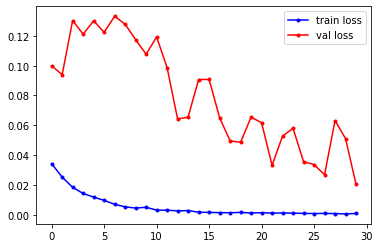

In [22]:
plt.plot(range(len(loss_vals)), [l[0] for l in loss_vals], 'b.-', label='train loss')
plt.plot(range(len(loss_vals)), [l[1] for l in loss_vals], 'r.-', label='val loss')
plt.legend()
plt.show()

**Saving the model**

In [23]:
torch.save(model.state_dict(), '/content/drive/MyDrive/FEMO2012 CHALLENGE /Dataset/model/cnn_lstm_model2.pth')

# Evaluating or Validating the Model Performance

**Loading the Model**

In [24]:
model.load_state_dict(torch.load('/content/drive/MyDrive/FEMO2012 CHALLENGE /Dataset/model/cnn_lstm_model1.pth'))

<All keys matched successfully>

**Applying Inference**

Inference - Inference refers to the process of using a trained machine learning model to make a prediction. Basically inference means validating the trained model

In [25]:
def model_inference_helper(model, dataloader):
    results = {'labels':[], 'predictions':[]}
    model.eval()
    for i, batch in enumerate(dataloader):
        x = batch['x'].to(device, dtype=torch.float)
        y = batch['y']

        with torch.no_grad():
            y_prediction = model(x)

        if y.size(0)>1:
            results['labels'] += y.squeeze().tolist()
            results['predictions'] += y_prediction.cpu().squeeze().tolist()
        elif y.size(0)==1:
            results['labels'].append(y.squeeze().tolist())
            results['predictions'].append(y_prediction.cpu().squeeze().tolist())
    return results

**sorting(= arranging in order) the results dictionary (i.e. sorting labels (actual values) and predicted values**

In [26]:
def sort_results(results):
    ind = [i[0] for i in sorted(enumerate(results['labels']), key=lambda x: x[1])]
    results['labels'] = [results['labels'][i] for i in ind]
    results['predictions'] = [results['predictions'][i] for i in ind]
    return results

In [29]:
def plot(i):
    train_results = model_inference_helper(model, train_dataloaders[i])
    val_results = model_inference_helper(model, val_dataloaders[i])
    results = {'labels': train_results['labels']+val_results['labels'], 'predictions': train_results['predictions']+val_results['predictions']}
    results = sort_results(results)

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=[20,5])
    ax[0].plot(range(len(results['labels'])), results['labels'], 'b.-', label='labels(actual values)')
    ax[0].plot(range(len(results['predictions'])), results['predictions'], 'r.-', label='predicted values')
    ax[0].legend()
    ax[1].scatter(train_results['labels'], train_results['predictions'], marker='.', c='b', label='train')
    ax[1].scatter(val_results['labels'], val_results['predictions'], marker='.', c='r', label='val')
    ax[1].scatter(results['labels'], results['labels'], marker='.', c='k', label='expected')
    ax[1].set_xlabel('true labels')
    ax[1].set_ylabel('predictions')
    ax[1].legend()
    plt.subplots_adjust(wspace=0.5)
    plt.show()

**Performance on Bearing1_1.pkz dataset**

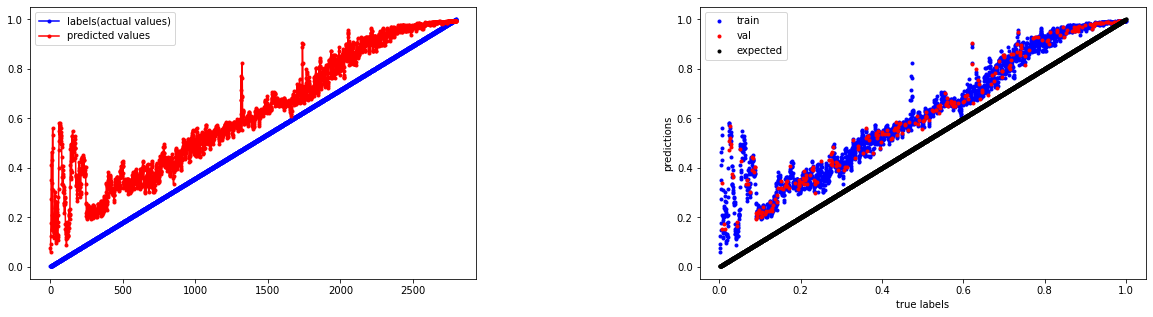

In [30]:
plot(0)

**Performance on Bearing1_2.pkz dataset**

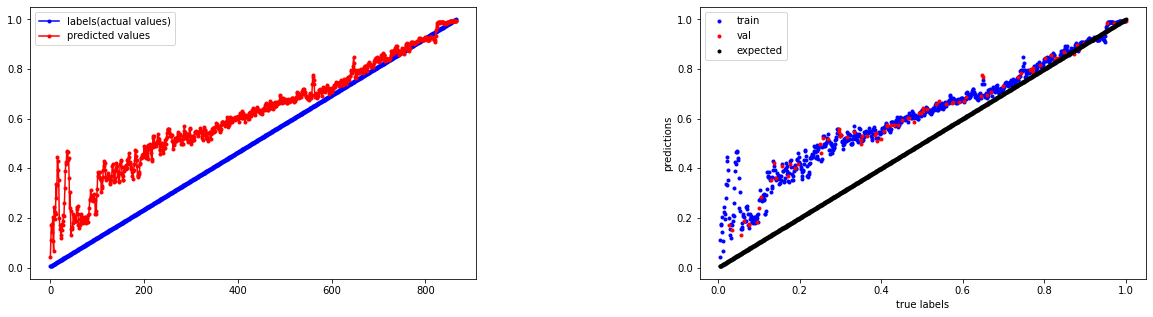

In [31]:
plot(1)

**Performance on Bearing2_1.pkz dataset**

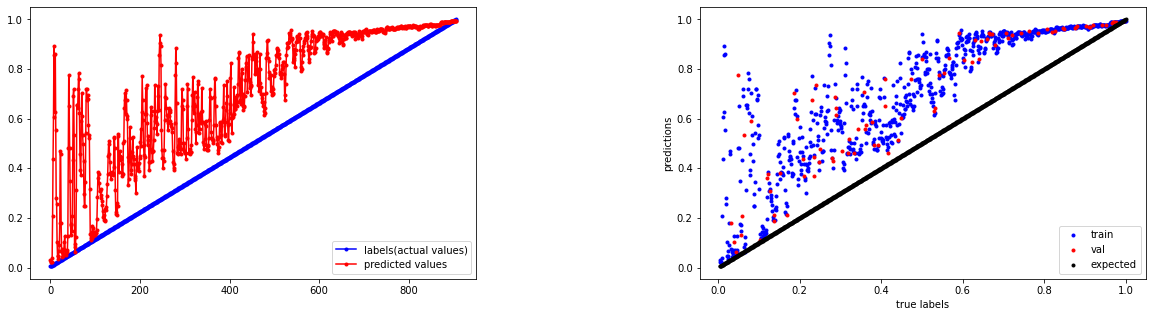

In [32]:
plot(2)

**Performance on Bearing2_2.pkz dataset**

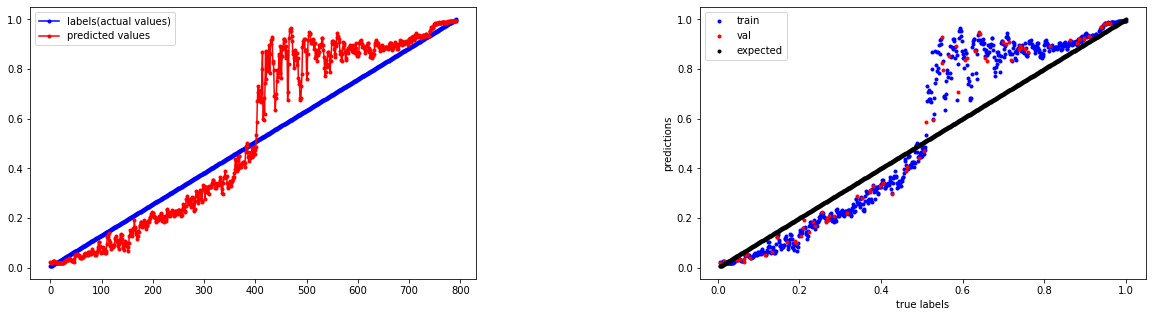

In [33]:
plot(3)

**Performance on Bearing3_1.pkz dataset**

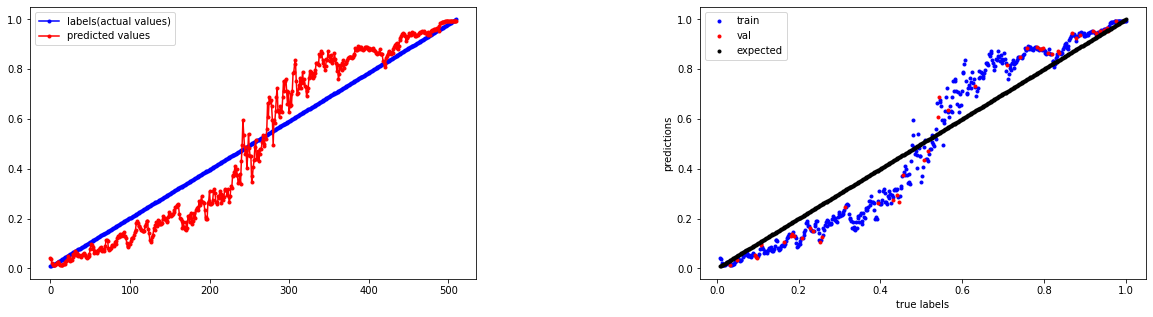

In [34]:
plot(4)

**Performance on Bearing3_2.pkz dataset**

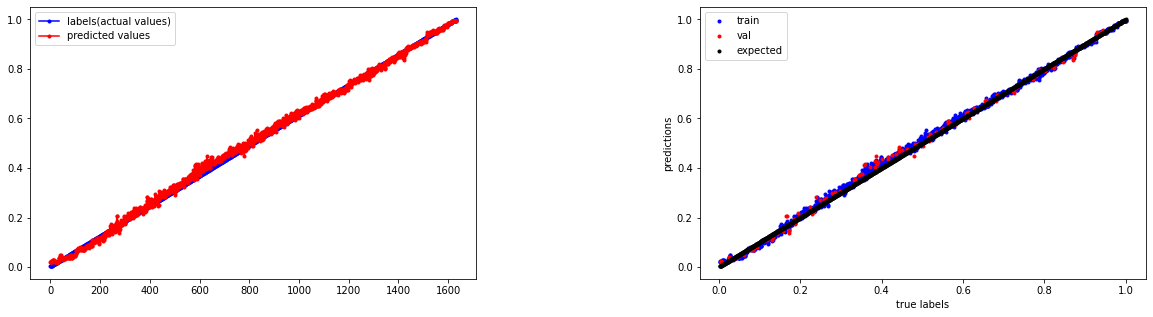

In [35]:
plot(5)